--- 

## Exercise 5 : ARIMAX versur ARDL models

### Imports

In [1]:
import polars as pl 
from datetime import date 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
# import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np


In [2]:
# function to evaluate an ARIMA based on AIC
def evaluate_arima_model(time_series, arima_order):
    try:
        model = ARIMA(time_series, order=arima_order)
        model_fit = model.fit()
        return arima_order, model_fit.aic
    except Exception as e:
        print(e)
        return arima_order, None
    
# function to plot acf/pacf
def plot_acf_pacf(time_series, lags=20):
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(time_series, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(time_series, lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()


### Preprocessing 

We start by importing the data and cleaning it

In [3]:
dep_var = (
    pl.read_excel(
        r"C:\Users\faune\timeseriescourse\CORBLACBS.xls", 
        read_options={'skip_rows':10}
    )
    .select(
        pl.col("^.*Graph.*$").alias("date"), 
        pl.col("^.*UNNAMED.*$").alias("corbl")
    )
)

We plot the data to get a sense of potential seasonality/ non stationarity, etc

we find no significant pattern in the data

<Axes: xlabel='date'>

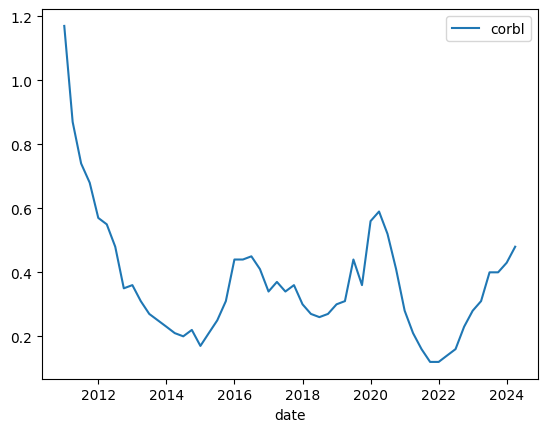

In [4]:
sns.lineplot(dep_var.to_pandas().set_index("date"))

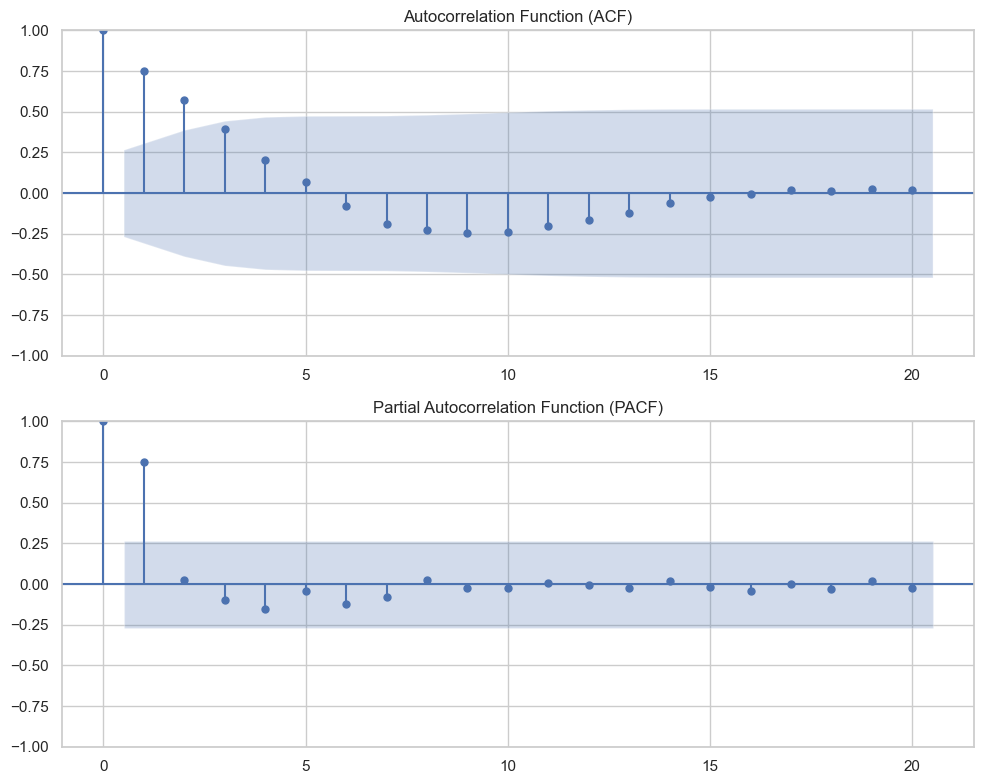

In [5]:
plot_acf_pacf(dep_var.select('corbl'))

We then split the data into train/test

In [6]:
in_sample = dep_var.filter(pl.col('date').lt(date(2023,1,1))) #stricly inferior
out_sample = dep_var.filter(pl.col('date').ge(date(2023,1,1)))

Then, we can fit the three different models in order to find the best one

We start with the ARIMA 

### ARIMA

In [7]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(in_sample.select("corbl").to_pandas()['corbl'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:-14.449043756492827
ARIMA(0, 0, 1) - AIC:-52.25780327659411
ARIMA(0, 0, 2) - AIC:-67.56891733223856
ARIMA(0, 0, 3) - AIC:-86.62591946537616
ARIMA(0, 0, 4) - AIC:-89.67342659832342
ARIMA(0, 1, 0) - AIC:-101.51000035129377
ARIMA(0, 1, 1) - AIC:-103.33153340945692
ARIMA(0, 1, 2) - AIC:-110.19446149841687
ARIMA(0, 1, 3) - AIC:-111.29712025084842
Best ARIMA(0, 1, 3) - AIC:-111.29712025084842


We then fit the ARIMA(0,1,3)

In [ ]:
model = ARIMA(in_sample.select("corbl").to_pandas()['corbl'], order=(0,1,3))
model_fit = model.fit()
in_sample_preds = model_fit.predict()
out_sample_preds = model_fit.forecast(6)

In [26]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  corbl   No. Observations:                   48
Model:                 ARIMA(0, 1, 3)   Log Likelihood                  59.649
Date:                Sun, 29 Dec 2024   AIC                           -111.297
Time:                        16:44:07   BIC                           -103.897
Sample:                             0   HQIC                          -108.512
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3778      0.123      3.070      0.002       0.137       0.619
ma.L2          0.6361      0.153      4.157      0.000       0.336       0.936
ma.L3          0.3517      0.159      2.209      0.0

In [16]:
predicted = pl.Series(in_sample_preds).append(pl.Series(out_sample_preds))

We then plot the results of the prediction vs the actual data

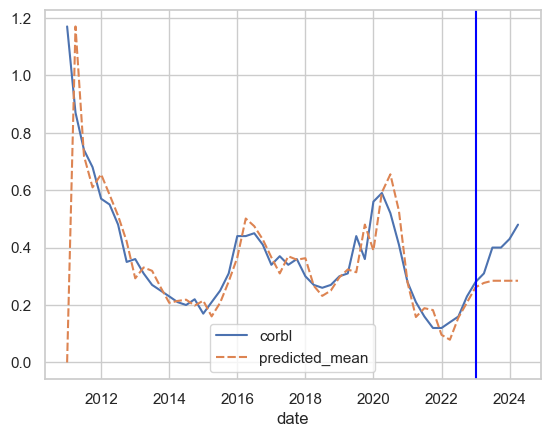

In [25]:
sns.lineplot(dep_var.with_columns(predicted).to_pandas().set_index('date'))
plt.axvline(date(2023,1,1), 0,1.2, color = 'blue')


We can see that there is a pretty large difference between the two 